<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Concrete_Crack_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Sprint #22: Concrete Crack Image Classification

https://drive.google.com/file/d/1ZKrbsUlrsTgJSlFMz2EGmTINFCQ8PcjO/view?usp=sharing

**Problem Statement**

Imagine you being a Civil Engineer with knowledge of Data Science and Machine Learning too. You are asked by your state/local government to find out all the cracked concrete and replace it with a new one. Now, with a good knowledge of Machine Learning / Deep Learning, you take a decision to build a system that would alert you when a cracked concrete is detected.


**Objective**

Build a Machine Learning or Deep Learning model that would help you detect the cracked concrete.

**Evaluation Criteria**
Accuracy_Score

**Data Description**

* train - contains all the cracked and not cracked concrete images that are to be used for training your model.  In this folder you will find two folders namely - ‘Negative’ contains concrete images with no crack in it, and ‘Positive’ contains cracked concrete images.

* test - contains concrete images. For these images you are required to make predictions as ‘Negative’ if the concrete is not cracked or ‘Positive’ if the concrete is cracked

* Testing_set_concrete_crack.csv - this is the order of the predictions for each image that is to be submitted on the platform. Make sure the predictions you download are with their image’s filename in the same order as given in this file.

* sample_submission: This is a csv file that contains the sample submission for the data sprint.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os


In [ ]:
image_dir = "/content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/"
os.listdir(image_dir)

['train',
 'test',
 '.ipynb_checkpoints',
 'sample_submission.csv',
 'Testing_set_concrete_crack.csv',
 'train.csv',
 'models']

In [ ]:
train_images = []
label = []
pos = "/content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train/Positive"
neg = "/content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train/Negative"
for img in os.listdir(pos):
  img_path = "Positive/"+img
  train_images.append(img_path)
  label.append('Positive')
#
for img in os.listdir(neg):
  img_path = "Negative/"+img
  train_images.append(img_path)
  label.append('Negative')

In [ ]:
#train_df = pd.DataFrame({'Image':train_images,'label':label})
train_df = pd.read_csv("/content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train.csv")

In [ ]:
train_df.shape

(28718, 2)

In [ ]:
df = train_df.sample(frac=1).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


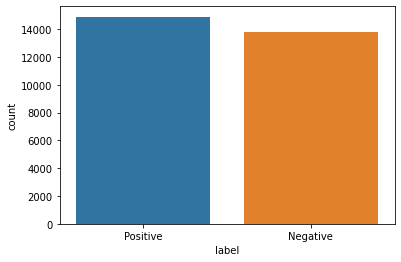

In [ ]:
sns.countplot(train_df['label'])

In [ ]:
df['label'].value_counts()

Positive    14900
Negative    13818
Name: label, dtype: int64

In [ ]:
train_df['label'].value_counts()

Positive    14900
Negative    13818
Name: label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


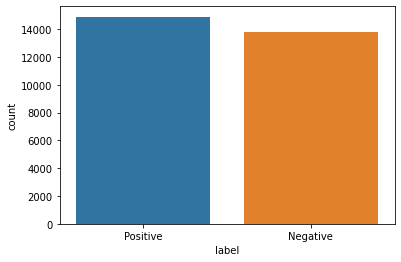

In [ ]:
sns.countplot(df['label'])

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/Testing_set_concrete_crack.csv")

In [ ]:
test_df.shape

(11282, 1)

In [ ]:
test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:
train_df.head()

,Image,label
0,Positive/13071_1.jpg,Positive
1,Positive/13072_1.jpg,Positive
2,Positive/13082_1.jpg,Positive
3,Positive/13093_1.jpg,Positive
4,Positive/13094_1.jpg,Positive


In [ ]:
train_df[train_df['Image'] == 'Negative/08394.jpg']

,Image,label
18127,Negative/08394.jpg,Negative


In [ ]:
df[df['Image'] == 'Negative/08394.jpg']

,Image,label
4,Negative/08394.jpg,Negative


In [ ]:
import os
import cv2
import glob
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score

#
import warnings
warnings.filterwarnings('ignore')
#
np.random.seed(1786)
ROOT = "/content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images"

In [ ]:
##transformations to be done to images
tfms = get_transforms(do_flip=False,flip_vert=False ,max_rotate=20.0, max_zoom=1.3, max_lighting=0.5, max_warp=0.1, p_affine=0.2,
                      p_lighting=0.55)
#, xtra_tfms=zoom_crop(scale=(0.9,1.8), do_rand=True, p=0.8))
data_folder = "/content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images"
## create databunch of test set to be passed
test_img = ImageList.from_df(test_df, path=data_folder, folder='test')

In [ ]:
test_img

ImageList (11282 items)
Image (3, 227, 227),Image (3, 227, 227),Image (3, 227, 227),Image (3, 227, 227),Image (3, 227, 227)
Path: /content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images

In [ ]:
np.random.seed(145)
## create source of train image databunch
src = (ImageList.from_df(train_df, path=ROOT, folder='train')
       .split_by_rand_pct(0.10)
       #.split_none()
       .label_from_df()
       .add_test(test_img))

In [ ]:
data = (src.transform(tfms, size=224,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=32, device= torch.device('cuda:0')).normalize(imagenet_stats))

In [ ]:
data = ImageDataBunch.from_folder(path=ROOT,
                                  train='train',
                                  valid_pct=0.2,
                                  test='test',
                                  ds_tfms=tfms, 
                                  size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)

In [ ]:
data.c,data.classes

(2, ['Negative', 'Positive'])

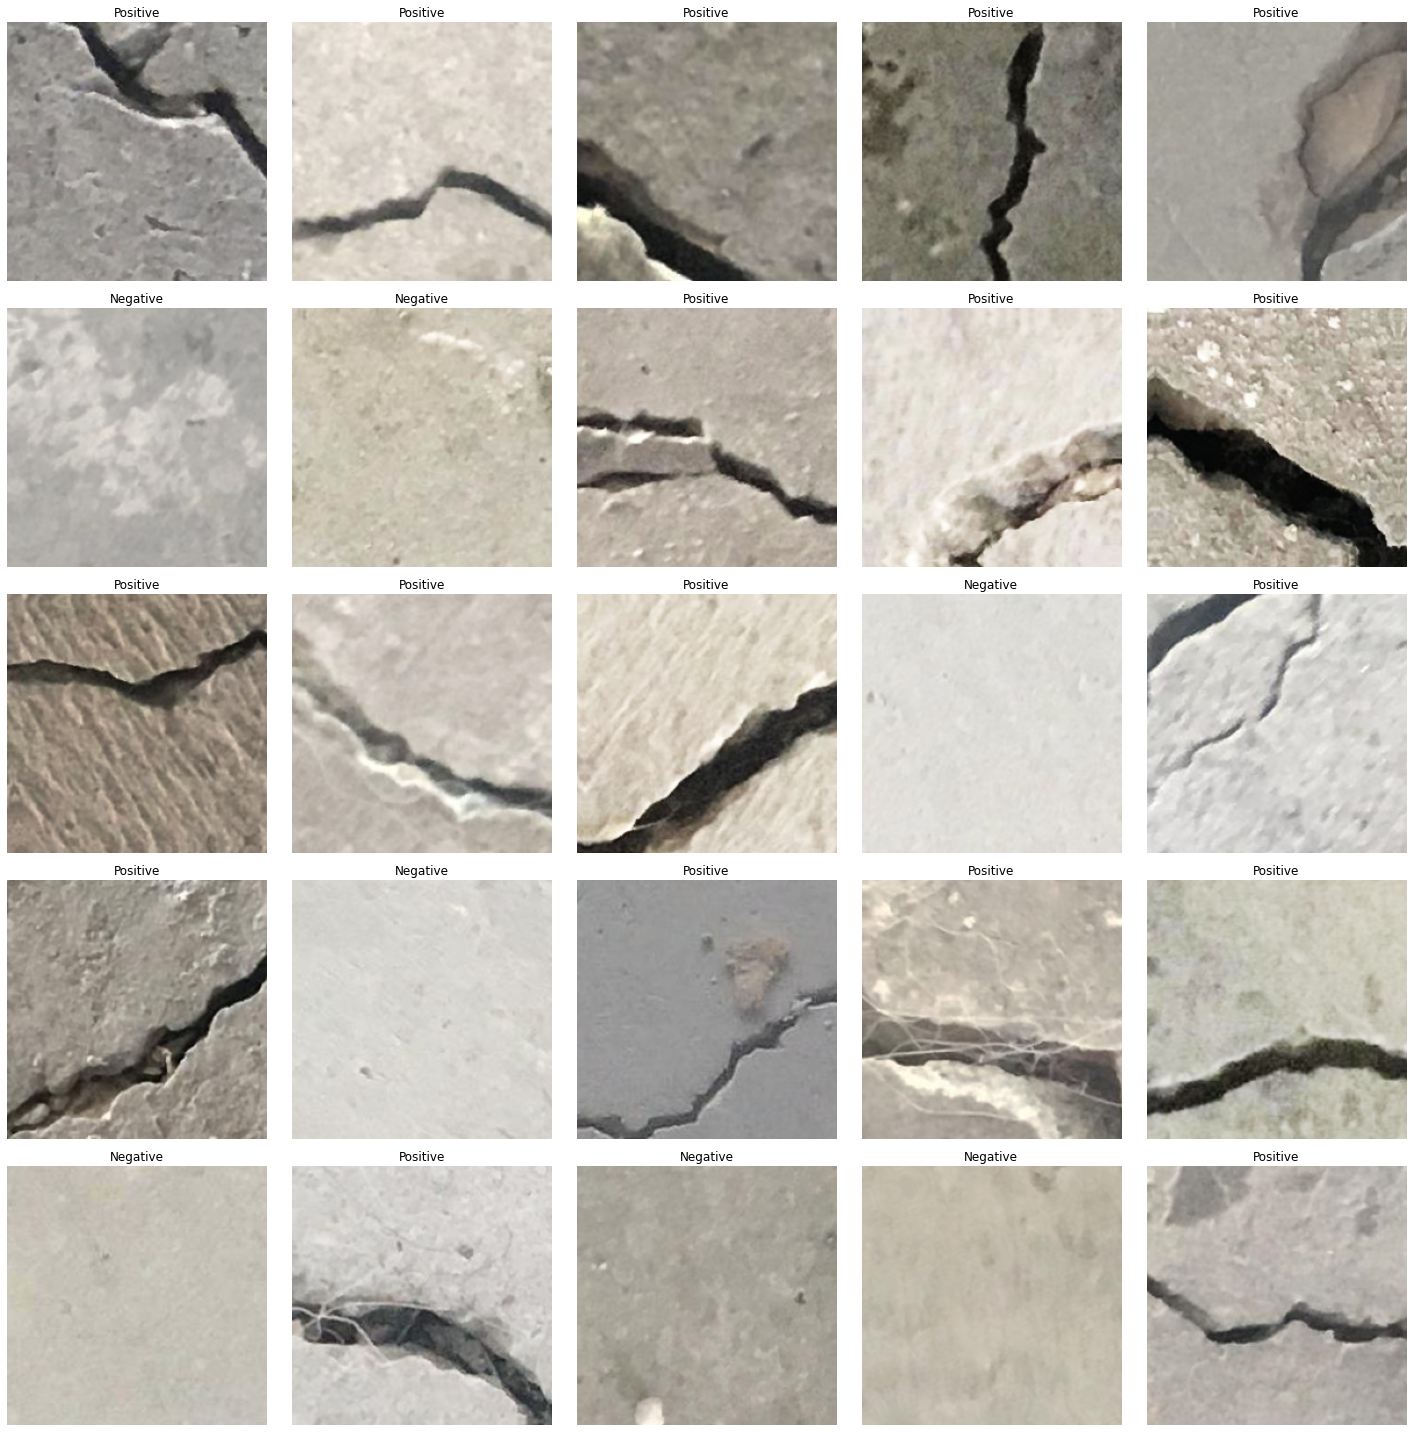

In [ ]:
data.show_batch()

**set train and test paths**

In [ ]:
train_path = "/content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train"
test_path = "/content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/test"

In [ ]:
learn = cnn_learner(data=data, base_arch=models.resnet152, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04
Min loss divided by 10: 8.32E-03


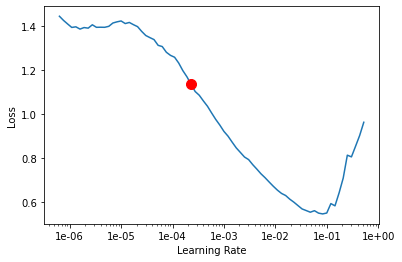

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.00022908676527677726

In [ ]:
learn.fit_one_cycle(5,max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.030575,0.022489,0.996517,07:06
1,0.055184,0.050096,0.993557,07:16
2,0.013205,0.013665,0.997910,07:16
3,0.003424,0.010329,0.997910,07:16
4,0.003713,0.008780,0.998085,07:16


In [ ]:
learn.save('stage-1')

In [ ]:
learn.fit_one_cycle(5,max_lr=min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.022239,0.007759,0.997562,1:05:55


epoch,train_loss,valid_loss,accuracy,time
0,0.022239,0.007759,0.997562,1:05:55
1,0.017531,0.005337,0.998258,07:23
2,0.012765,0.006791,0.997910,07:39
3,0.007264,0.004525,0.998955,07:40
4,0.005810,0.003973,0.998955,07:39


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (25847 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Positive,Positive,Positive,Positive,Positive
Path: /content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images;

Valid: LabelList (2871 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Positive,Negative,Negative,Positive,Negative
Path: /content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images;

Test: LabelList (11282 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=

In [ ]:
learn.unfreeze()


In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.070087,0.030876,0.989551,10:44
1,0.041915,0.010360,0.997562,10:38
2,0.014546,0.014052,0.996865,10:34
3,0.010512,0.007055,0.998258,10:34
4,0.005599,0.006715,0.997910,10:34


**Inference**

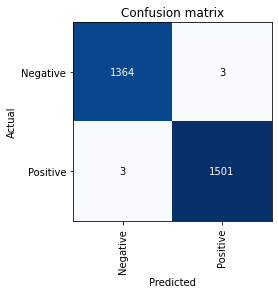

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**Evaluation before unfreeze**

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
val_preds = np.exp(val_preds.numpy())
print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
print("Accuracy Score ",accuracy_score(y.numpy(), np.argmax(val_preds,axis=1)))

F1 score for this fold  0.9982584753338095
Accuracy Score  0.9982584465343086


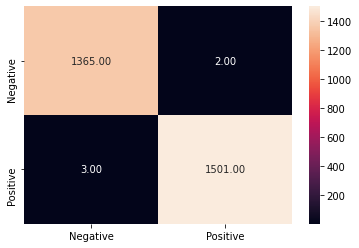

In [ ]:
sns.heatmap(confusion_matrix(y.numpy(), np.argmax(val_preds,axis=1)),annot=True,fmt=".2f",xticklabels=data.classes,yticklabels=data.classes)

**predictions before unfreeze**

In [ ]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
#preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i])+1 for i in range(len(preds))]
labelled_preds = np.array(labelled_preds)

      image_id  label
0  Image_1.jpg      1
1  Image_2.jpg      1
2  Image_3.jpg      1
3  Image_4.jpg      1
4  Image_5.jpg      2
      image_id  label prediction
0  Image_1.jpg      1   Negative
1  Image_2.jpg      1   Negative
2  Image_3.jpg      1   Negative
3  Image_4.jpg      1   Negative
4  Image_5.jpg      2   Positive


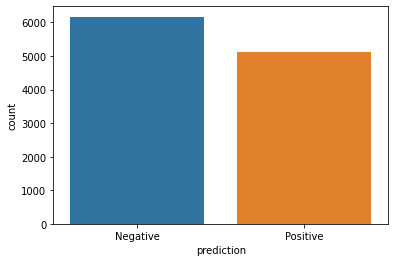

In [ ]:
#
df = pd.DataFrame({'image_id':test_df['filename'], 'label':labelled_preds})
print(df.head())
#
df['prediction'] =df['label'].apply(lambda x : data.classes[x-1])
print(df.head())
sns.countplot(df['prediction'])

In [ ]:
df['prediction'].to_csv("sub2.csv",index=False)

**DPHi 22 Score for resnet153 without cross valiadtion : 99.89363588016309**

In [ ]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [ ]:
if __name__=="__main__":
    #train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(1):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT, folder="train").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=3).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy], ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(4)
        learn.unfreeze()
        learn.fit_one_cycle(2, max_lr=1e-4, callbacks=[cb])
        #learn.fit_one_cycle(5, max_lr=5e-5, callbacks=[cb])
        learn.fit_one_cycle(3, max_lr=1e-5, callbacks=[cb])
        learn.fit_one_cycle(2, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(3, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        print("accuracy score for this fold ",accuracy_score(y.numpy(), np.argmax(val_preds,axis=1)))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
        shutil.copy(src, fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)


(28718, 2) (11282, 1)
Starting fold 0
(26923,) (1795,)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.046252,0.006026,0.002786,0.997214,54:24
1,0.027838,0.002955,0.001114,0.998886,01:43
2,0.025888,0.004767,0.001671,0.998329,01:43
3,0.036300,0.002802,0.001671,0.998329,01:43


epoch,train_loss,valid_loss,error_rate,accuracy,time
epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.022768,0.002461,0.000000,1.000000,01:48
1,0.010671,0.000843,0.000000,1.000000,01:48


Save the best acc 0.00000
Save the best acc 0.00000


epoch,train_loss,valid_loss,error_rate,accuracy,time
epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.012795,0.000470,0.000000,1.000000,01:47
1,0.006472,0.000349,0.000000,1.000000,01:48
2,0.006252,0.000323,0.000000,1.000000,01:48


Save the best acc 0.00000
Save the best acc 0.00000
Save the best acc 0.00000


epoch,train_loss,valid_loss,error_rate,accuracy,time
epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.007299,0.000221,0.000000,1.000000,01:48
1,0.011860,0.000275,0.000000,1.000000,01:48


Save the best acc 0.00000


epoch,train_loss,valid_loss,error_rate,accuracy,time
epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.003570,0.000248,0.000000,1.000000,01:48
1,0.004868,0.000391,0.000000,1.000000,01:49
2,0.009130,0.000271,0.000000,1.000000,01:49


F1 score for this fold  1.0
accuracy score for this fold  1.0


In [ ]:
x = np.argmax(test_preds_all, axis=1)
x                                                       

array([0, 0, 0, 0, ..., 1, 0, 1, 0])

In [ ]:
xx=['Negative', 'Positive']
y=[]
for i in x:
  y.append(xx[i])

In [ ]:
submission = pd.DataFrame({
        "prediction":y
    })
submission.to_csv('./DPHI_concrete_resnet50_cv3.csv', index=False)
print(submission)

      prediction
0       Negative
1       Negative
2       Negative
3       Negative
4       Positive
...          ...
11277   Negative
11278   Positive
11279   Negative
11280   Positive
11281   Negative

[11282 rows x 1 columns]


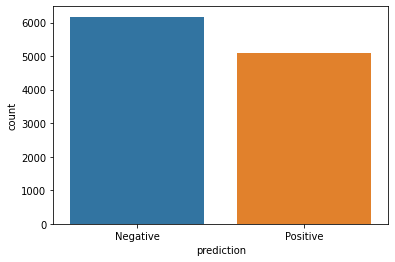

In [ ]:
sns.countplot(submission['prediction'])

**VGG16- Cross-Validation Scores-99.90249955681617**

**Resnet152- Cross-Validation Scores-99.92022691012232**

**Densenet169 -Cross Validation Scores - 99.92909058677539**

**Densenet201 -Cross Validation Scores - 99.89363588016309**

**Densenet121 -Cross Validation Scores - 99.93795426342848**

**Resnet50 -Cross Validation Scores -99.94681794008154**

**Resnet34 - Cross Validation Scores -99.93795426342848**


**Need to try Densenet201**

      filename  label prediction
0  Image_1.jpg      0   Negative
1  Image_2.jpg      0   Negative
2  Image_3.jpg      0   Negative
3  Image_4.jpg      0   Negative
4  Image_5.jpg      1   Positive


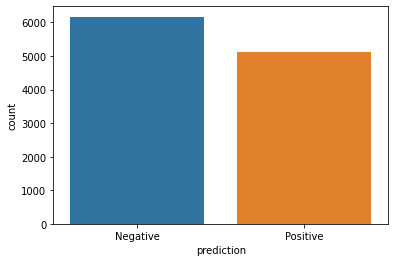

In [ ]:
submission['prediction'] =submission['label'].apply(lambda x : data.classes[x])
print(submission.head())
sns.countplot(submission['prediction'])

In [ ]:
submission[['prediction']].to_csv("stratifiedkfold.csv",index=False)

In [ ]:
test_df['prediction'] = labelled_preds

In [ ]:
data.classes

['Negative', 'Positive']

In [ ]:
label_mapper = {1:'Negative',2:'Positive'}

In [ ]:
test_df.head()

,filename,Label,prediction
0,Image_1.jpg,1,1
1,Image_2.jpg,2,2
2,Image_3.jpg,2,2
3,Image_4.jpg,1,1
4,Image_5.jpg,2,2


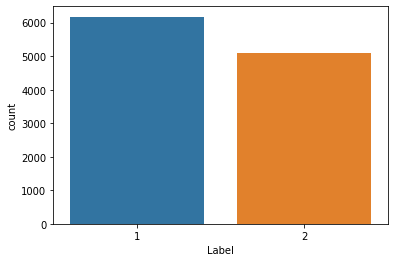

In [ ]:
sns.countplot(test_df['Label'])

**Dphi Score for cross validation - 99.84045382024463**

## Trying Fastai2

In [ ]:
train_df.head()

,Image,label
0,Positive/13071_1.jpg,Positive
1,Positive/13072_1.jpg,Positive
2,Positive/13082_1.jpg,Positive
3,Positive/13093_1.jpg,Positive
4,Positive/13094_1.jpg,Positive


In [ ]:
test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 727kB 8.7MB/s 
     |████████████████████████████████| 1.2MB 49.0MB/s 
     |████████████████████████████████| 194kB 52.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
Mounted at /content/gdrive


In [ ]:
import fastai
import torch
import torchvision
import fastbook
print("Fastbook : ",fastbook.__version__)
print("torchvision : ",torchvision.__version__)
print("torch : ",torch.__version__)
print("fastai : ",fastai.__version__)

Fastbook :  0.0.16
torchvision :  0.8.1+cu101
torch :  1.7.0+cu101
fastai :  2.2.5


In [ ]:
train_df.to_csv("/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train.csv",index=False)

In [ ]:
item_tfms = Resize(256)
batch_tfms = [RandomResizedCrop(224), *aug_transforms(mult=1.0, do_flip=True, max_rotate=30.0, max_zoom=1.5,
                            max_lighting=.8, max_warp=0.3, p_lighting=.9)]

In [ ]:
path = Path("/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train")

In [ ]:
get_image_files(path)

(#28718) [Path('/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train/Negative/11324.jpg'),Path('/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train/Negative/11323.jpg'),Path('/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train/Negative/11325.jpg'),Path('/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train/Negative/11326.jpg'),Path('/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train/Negative/11327.jpg'),Path('/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train/Negative/11328.jpg'),Path('/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train/Negative/11330.jpg'),Path('/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train/Negative/11329.jpg'),Path('/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train/Negative/11331.jpg'),Path('/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_imag

In [ ]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  splitter = RandomSplitter(),
                  get_items=get_image_files,
                  get_y=parent_label,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms)

In [ ]:
dls = block.dataloaders(path, bs=32)

In [ ]:
dls.c,dls.vocab

(2, ['Negative', 'Positive'])

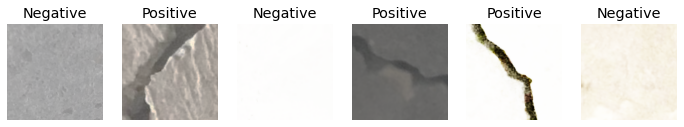

In [ ]:
dls.train.show_batch(max_n=6,nrows=1,figsize=(12,8))

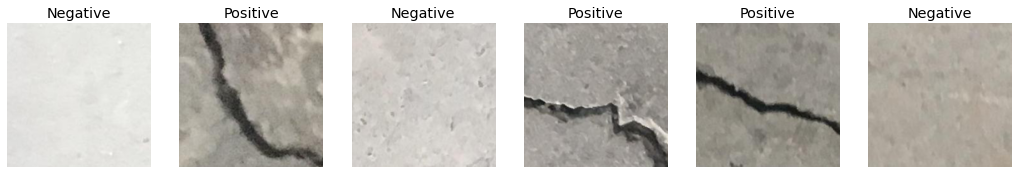

In [ ]:
dls.valid.show_batch(max_n=6,nrows=1)

In [ ]:
learn = cnn_learner(dls, densenet121, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


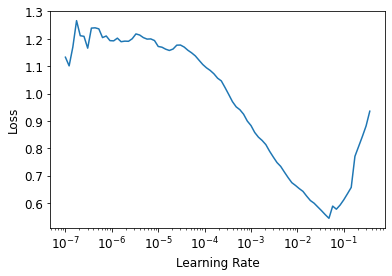

In [ ]:
lr_min,lr_max = learn.lr_find()

In [ ]:
lr_min,lr_max

(0.004786301031708717, 0.0003311311302240938)

**fitting the data with cosine annealing**

In [ ]:
learn.fit_flat_cos(5,lr=slice(lr_min,lr_max))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.049069,0.006084,0.002264,0.997736,40:11
1,0.054170,0.004282,0.000871,0.999129,03:37
2,0.042085,0.004904,0.000871,0.999129,03:37
3,0.032311,0.007953,0.002264,0.997736,03:37
4,0.031020,0.002086,0.000697,0.999304,03:37


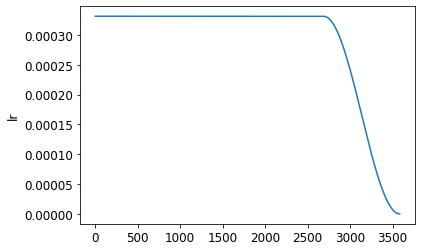

In [ ]:
learn.recorder.plot_sched()

In [ ]:
learn.fine_tune(10,cbs=EarlyStoppingCallback())

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.033081,0.009650,0.003308,0.996692,03:37


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.015363,0.001119,0.000174,0.999826,04:38
1,0.042155,0.002431,0.000348,0.999652,04:36


No improvement since epoch 0: early stopping


In [ ]:
val_preds = learn.tta()

In [ ]:
val_preds 

(tensor([[9.9966e-01, 3.3868e-04],
         [2.6126e-05, 9.9997e-01],
         [9.9995e-01, 5.0296e-05],
         ...,
         [9.8833e-01, 1.1667e-02],
         [9.7634e-05, 9.9990e-01],
         [3.0543e-04, 9.9969e-01]]), TensorCategory([0, 1, 0,  ..., 0, 1, 1]))

In [ ]:
test_path = "/content/gdrive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/test"
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files)
pred_probas, _, pred_classes = learn.get_preds(dl=test_dl, with_decoded=True) 

In [ ]:
target,predictions = learn.tta(dl=test_dl)

In [ ]:
target

tensor([[2.0504e-04, 9.9979e-01],
        [9.9966e-01, 3.3823e-04],
        [2.1918e-04, 9.9978e-01],
        ...,
        [9.9986e-01, 1.4358e-04],
        [9.9993e-01, 7.2600e-05],
        [9.9986e-01, 1.3730e-04]])

In [ ]:
x = [i.argmax().item() for i in target]

In [ ]:
from sklearn.model_selection import StratifiedKFold
def get_dls(bs, size, val_idx):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=IndexSplitter(val_idx),
                   #item_tfms = Resize(256),
                   batch_tfms = [RandomResizedCrop(size), 
                                 *aug_transforms(mult=1.0, do_flip=True, 
                                                 max_rotate=30.0, max_zoom=1.5,
                                                  max_lighting=.8, max_warp=0.3, 
                                                 p_lighting=.9),
                                 Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [ ]:
imgs = get_image_files(path)
random.shuffle(imgs)
lbls = [parent_label(im) for im in imgs]

In [ ]:
lbls

['Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',

In [ ]:
val_pct = []
test_preds_all = []
skf = StratifiedKFold(n_splits=2, shuffle=True)
i = 0

for _, val_idx in skf.split(np.array(imgs), lbls):
  dls = get_dls(32, 128, val_idx)
  learn = cnn_learner(dls, densenet121, metrics=[error_rate,accuracy])
  learn.fine_tune(2, cbs=[EarlyStoppingCallback(monitor='valid_loss')])
  learn.dls = get_dls(32, 224, val_idx)
  learn.fine_tune(2, 1e-3, cbs=[EarlyStoppingCallback(monitor='valid_loss')])
  preds,targs = learn.tta()
  print(accuracy(preds, targs).item())
  val_pct.append(accuracy(preds, targs).item())
  test_preds = np.exp(learn.tta(dl=test_dl)[0].numpy())
  test_preds_all.append(test_preds)
  i+=1

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.093086,0.013215,0.004457,0.995543,02:20


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.053802,0.009550,0.003691,0.996309,02:51
1,0.022464,0.004716,0.001532,0.998468,02:50


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.026517,0.006740,0.002229,0.997771,02:27


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.021845,0.005666,0.001393,0.998607,02:50
1,0.018511,0.004447,0.001323,0.998677,02:50


0.9986767768859863


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.090204,0.010080,0.002855,0.997145,02:18


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.040392,0.007820,0.002159,0.997841,02:49
1,0.028795,0.005027,0.001323,0.998677,02:50


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.036991,0.006093,0.002229,0.997771,02:26


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.017924,0.003858,0.001323,0.998677,02:50
1,0.016233,0.003967,0.001045,0.998955,02:49


No improvement since epoch 0: early stopping


0.9990249872207642


In [ ]:
val_pct 

NameError: ignored

In [ ]:
len(test_preds_all)

2

In [ ]:
test_preds_all[0]

array([[1.0004442, 2.7170749],
       [2.7105818, 1.0028408],
       [1.0000373, 2.7181804],
       ...,
       [2.7177427, 1.0001985],
       [2.716918 , 1.000502 ],
       [2.714333 , 1.0014548]], dtype=float32)

In [ ]:
test_preds_all = np.mean(test_preds_all, axis=0)

In [ ]:
x = np.argmax(test_preds_all, axis=1)
x 

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
submission = pd.DataFrame({
        "filename":test_df['filename'],
        "label":x
    })

print(submission)

              filename  label
0          Image_1.jpg      1
1          Image_2.jpg      0
2          Image_3.jpg      1
3          Image_4.jpg      1
4          Image_5.jpg      0
...                ...    ...
11277  Image_11278.jpg      0
11278  Image_11279.jpg      1
11279  Image_11280.jpg      0
11280  Image_11281.jpg      0
11281  Image_11282.jpg      0

[11282 rows x 2 columns]


      filename  label prediction
0  Image_1.jpg      1   Positive
1  Image_2.jpg      0   Negative
2  Image_3.jpg      1   Positive
3  Image_4.jpg      1   Positive
4  Image_5.jpg      0   Negative


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


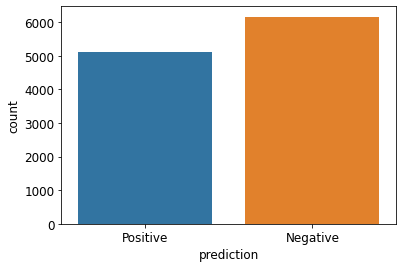

In [ ]:
submission['prediction'] =submission['label'].apply(lambda x : dls.vocab[x])
print(submission.head())
sns.countplot(submission['prediction'])

In [ ]:

submission[['prediction']].to_csv('./DPHI_concrete_resnet152_fastai212.csv', index=False)
print(submission)

              filename  label prediction
0          Image_1.jpg      1   Positive
1          Image_2.jpg      0   Negative
2          Image_3.jpg      1   Positive
3          Image_4.jpg      1   Positive
4          Image_5.jpg      0   Negative
...                ...    ...        ...
11277  Image_11278.jpg      0   Negative
11278  Image_11279.jpg      1   Positive
11279  Image_11280.jpg      0   Negative
11280  Image_11281.jpg      0   Negative
11281  Image_11282.jpg      0   Negative

[11282 rows x 3 columns]


**Ensemble Techniques**

In [ ]:
data_folder = Path("/content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images")

In [ ]:
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1,
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75 ,xtra_tfms=[contrast(scale=(0.5, 1), p=0.75)])

In [ ]:
imagesize = 64
batchsize = 64

In [ ]:
## create databunch of test set to be passed
test_img = ImageList.from_df(test_df, path=data_folder, folder='test')

In [ ]:
data_folder/'train'

PosixPath('/content/drive/MyDrive/Adrain/Concrete_data/concrete_cracked_images/train')

In [ ]:
### Created the function train data as I wanted to vary the image sizes while training and it will give some flexibility 
### in creating data 
def train_data (imagesize,batchsize) : 
    train_img = (ImageList.from_df(train_df, path=data_folder, folder='train')
        .split_by_rand_pct(0.2,seed =344) ##20% of the data is used as validation
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=imagesize)
        .databunch(path='.', bs=batchsize, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )
    return train_img

In [ ]:
data = train_data(imagesize,batchsize)

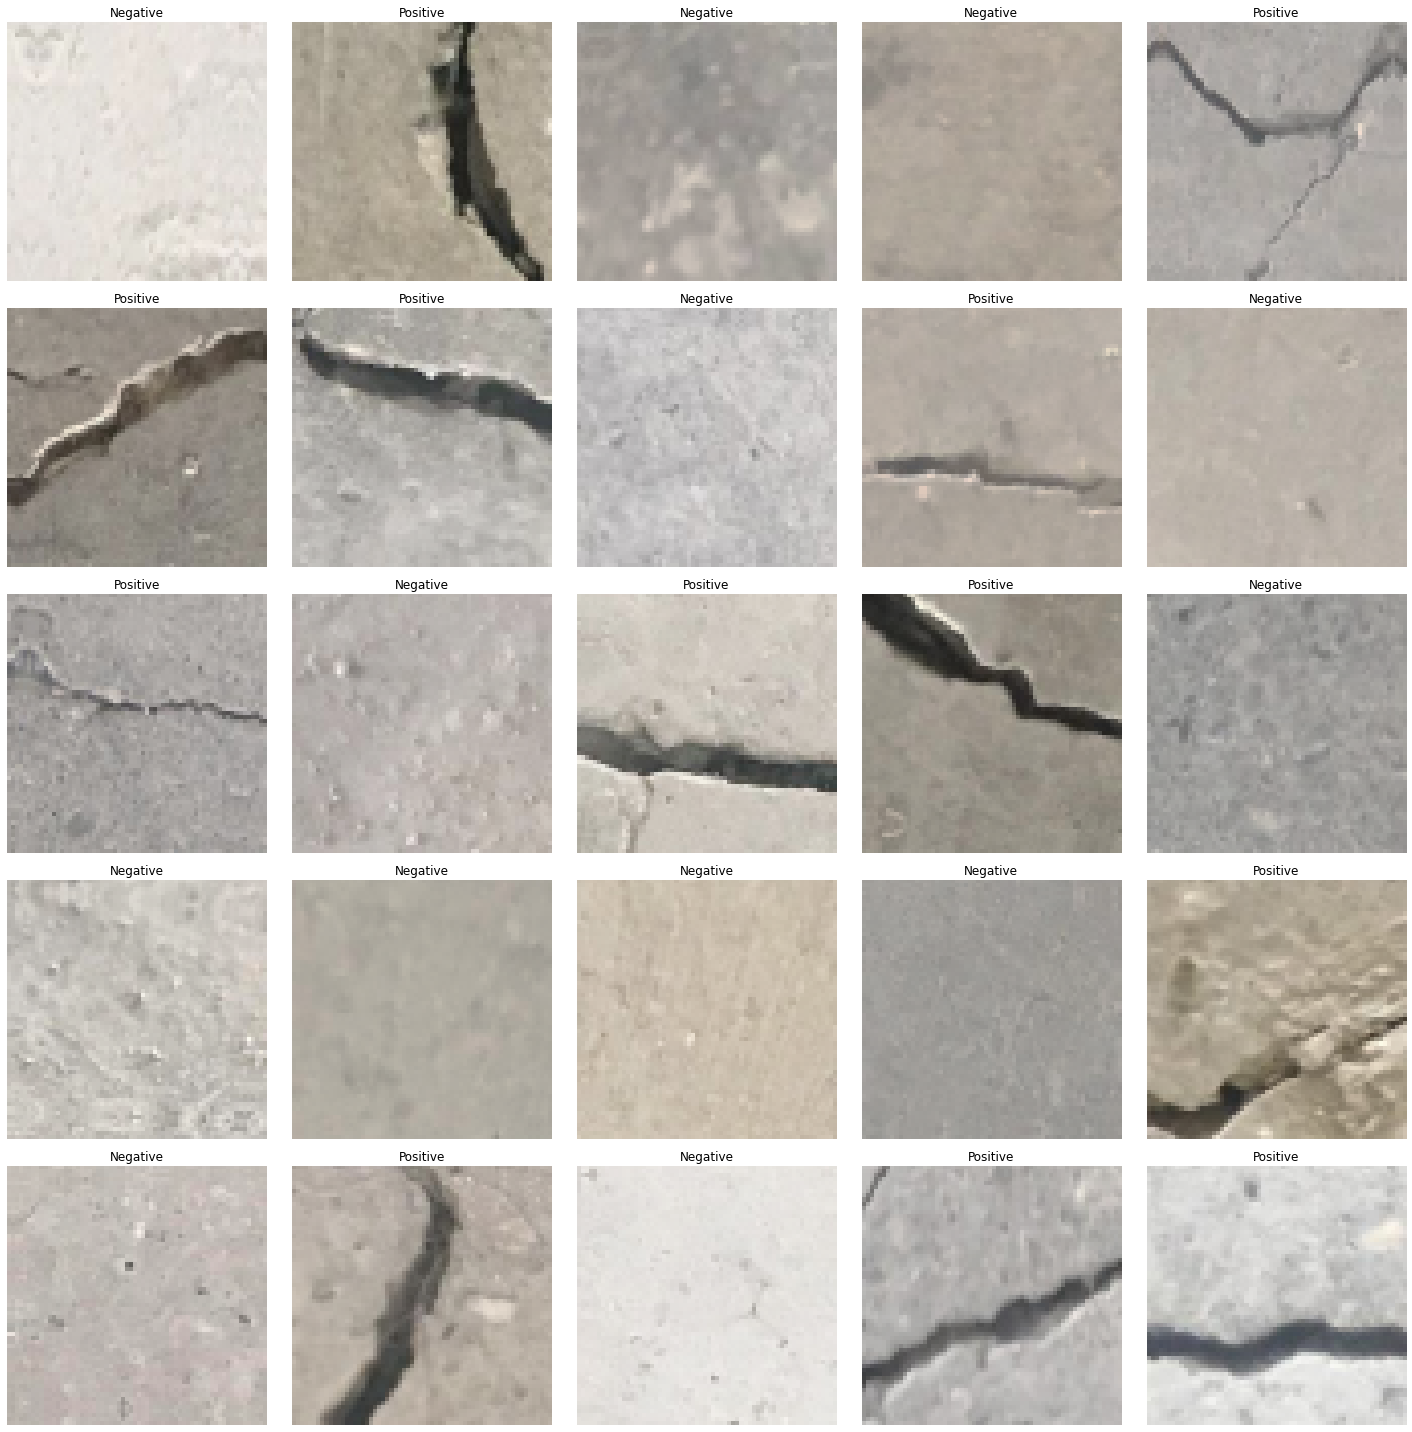

In [ ]:
data.show_batch()

----------------------------------
-----Training model: 1--------
----------------------------------


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



training for 128x128


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-04
Min loss divided by 10: 2.51E-02


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.096715,0.020351,0.007487,0.992513,0.999788,43:59
1,0.032792,0.010777,0.003308,0.996692,0.999918,01:08
2,0.029777,0.004507,0.001567,0.998433,0.999988,01:05
3,0.025014,0.003531,0.001567,0.998433,0.999995,01:05
4,0.023976,0.003439,0.001045,0.998955,0.999997,01:05


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.024119,0.004097,0.002090,0.997910,0.999991,01:06
1,0.018191,0.002311,0.000697,0.999304,0.999999,01:06
2,0.013848,0.004268,0.000871,0.999129,0.999987,01:06
3,0.008671,0.002624,0.000522,0.999478,1.000000,01:06
4,0.003196,0.001439,0.000348,0.999652,1.000000,01:06


training for 150x150


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.011000,0.001752,0.000522,0.999478,1.000000,01:06
1,0.011286,0.001445,0.000348,0.999652,1.000000,01:05
2,0.001877,0.000317,0.000000,1.000000,1.000000,01:06


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.005481,0.005913,0.001915,0.998085,0.999995,01:06
1,0.009295,0.001495,0.000348,0.999652,1.000000,01:06
2,0.005214,0.000638,0.000174,0.999826,1.000000,01:06
3,0.003424,0.001402,0.000348,0.999652,1.000000,01:06
4,0.002490,0.000464,0.000000,1.000000,1.000000,01:06


-----Training of model 1 complete----
----------------------------------
-----Training model: 2--------
----------------------------------


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



training for 128x128


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.74E-02


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.056581,0.027061,0.004701,0.995299,0.999213,01:12
1,0.021718,0.015501,0.002438,0.997562,0.999383,01:12
2,0.020936,0.098103,0.006791,0.993209,0.994155,01:12
3,0.010208,0.088528,0.005920,0.994080,0.994514,01:13
4,0.017511,0.024966,0.004353,0.995647,0.998761,01:14


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.025047,0.003522,0.001045,0.998955,0.999989,01:24
1,0.020151,0.004239,0.001045,0.998955,0.999995,01:23
2,0.019729,0.004855,0.000348,0.999652,0.999944,01:24
3,0.009347,0.001548,0.000348,0.999652,0.999998,01:24
4,0.004984,0.000891,0.000348,0.999652,1.000000,01:23


training for 150x150


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.027066,0.006343,0.001393,0.998607,0.999991,01:23
1,0.012973,0.002493,0.000348,0.999652,0.999998,01:23
2,0.008292,0.001865,0.000871,0.999129,0.999999,01:22


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.011051,0.001229,0.000174,0.999826,1.000000,01:23
1,0.014163,0.002482,0.000697,0.999304,0.999998,01:22
2,0.008388,0.000435,0.000174,0.999826,1.000000,01:22
3,0.004460,0.001661,0.000871,0.999129,0.999999,01:23
4,0.005176,0.001786,0.000522,0.999478,0.999999,01:23


-----Training of model 2 complete----
----------------------------------
-----Training model: 3--------
----------------------------------


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth



training for 128x128


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 1.45E-02


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.023124,0.007955,0.001219,0.998781,0.999704,01:22
1,0.027004,0.004001,0.000871,0.999129,0.999995,01:21
2,0.016655,0.001725,0.000522,0.999478,0.999999,01:22
3,0.006497,0.004062,0.000697,0.999304,0.999913,01:21
4,0.005554,0.004127,0.000522,0.999478,0.999714,01:22


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.019336,0.003951,0.001567,0.998433,0.999998,01:31
1,0.030998,0.004044,0.001567,0.998433,0.999998,01:32
2,0.014635,0.001301,0.000522,0.999478,1.000000,01:31
3,0.009176,0.001570,0.000697,0.999304,1.000000,01:31
4,0.006473,0.001101,0.000348,0.999652,0.999999,01:31


training for 150x150


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.018605,0.003607,0.000697,0.999304,0.999999,01:31
1,0.018388,0.002054,0.001045,0.998955,1.000000,01:31
2,0.008159,0.001330,0.000522,0.999478,1.000000,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.049317,0.016053,0.004353,0.995647,0.999599,01:31
1,0.011256,0.003635,0.001045,0.998955,0.999995,01:31
2,0.010131,0.004063,0.000697,0.999304,0.999996,01:31
3,0.006005,0.002199,0.000871,0.999129,0.999999,01:32
4,0.005428,0.001526,0.000697,0.999304,0.999999,01:32


-----Training of model 3 complete----
----------------------------------
-----Training model: 4--------
----------------------------------


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



training for 128x128


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 3.02E-02


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.040329,0.026443,0.007139,0.992861,0.999795,01:10
1,0.020836,0.019363,0.004527,0.995473,0.999995,01:09
2,0.023418,0.001167,0.000174,0.999826,0.999999,01:09
3,0.008953,0.000966,0.000697,0.999304,1.000000,01:09
4,0.007753,0.000806,0.000522,0.999478,1.000000,01:09


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.039447,0.010356,0.003134,0.996866,0.999960,01:15
1,0.026734,0.007504,0.002090,0.997910,0.999994,01:15
2,0.014059,0.003785,0.001219,0.998781,0.999999,01:16
3,0.009312,0.001534,0.000348,0.999652,1.000000,01:16
4,0.004633,0.001282,0.000348,0.999652,0.999999,01:15


training for 150x150


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.024481,0.003750,0.001045,0.998955,0.999992,01:15
1,0.012268,0.002075,0.000871,0.999129,0.999999,01:16
2,0.005501,0.001922,0.001045,0.998955,0.999999,01:17


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.016087,0.003947,0.000871,0.999129,0.999997,01:16
1,0.016721,0.004289,0.001741,0.998259,0.999998,01:16
2,0.010876,0.002396,0.000697,0.999304,1.000000,01:16
3,0.005089,0.001308,0.000522,0.999478,0.999999,01:16
4,0.012883,0.001538,0.000522,0.999478,0.999999,01:16


-----Training of model 4 complete----


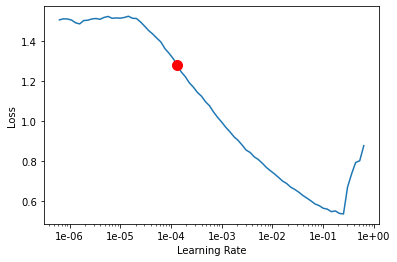

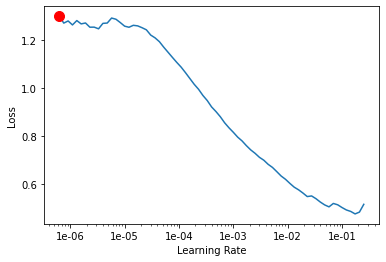

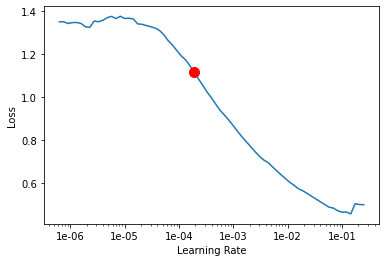

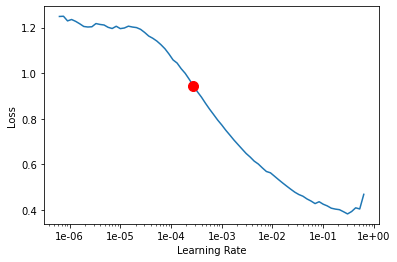

In [ ]:
nmodels = 4
def get_ensemble(nmodels):
    ens_model = [] # Empty List of ensemble model, I will store the trained learner object here 
    lr = 1e-2
    learning_rate =[lr/9,lr/3,lr/2,lr] # List of learning rate for each model 
    model_list = [models.resnet50,models.resnet152,models.densenet169,models.densenet121] ##List of Models . You can add resnet ones in the mix
    for i in range(nmodels):
        print(f'----------------------------------')
        print(f'-----Training model: {i+1}--------')
        print(f'----------------------------------')
             
        data = train_data(64,64)
        learn_resnet = cnn_learner(data, model_list[i], metrics=[error_rate, accuracy,AUROC()],
                                   model_dir="/tmp/model/")

        print('training for 128x128')
        learn_resnet.set_data = train_data(128,64) # Train the model for imagesize 128
        learn_resnet.lr_find()
        learn_resnet.recorder.plot(suggestion=True)
        learn_resnet.fit_one_cycle(5,slice(learning_rate[i])) # using the learning rate for the first model 
        #
        learn_resnet.unfreeze()
        learn_resnet.fit_one_cycle(5,slice(learning_rate[i]))
        #
        print('training for 150x150')
        learn_resnet.set_data = train_data(150,96) #Train the model for imagesize 150
        learn_resnet.fit_one_cycle(3,slice(learning_rate[i]))   # using the learning rate assigned for the first model   
        #
        learn_resnet.unfreeze()
        learn_resnet.fit_one_cycle(5,slice(learning_rate[i]))
        #
        learn_resnet.save(f'ensem_model_{i}.weights')
        ens_model.append(learn_resnet)
        print(f'-----Training of model {i+1} complete----')
    return ens_model
ens = get_ensemble(4) # ens is a list type of object which will contain my three learnt model

**Confusion Matrix**

• Positive (P) : Observation is positive (for example: is a cactus). 

• Negative (N) : Observation is not positive (for example: is not a cactus). 

• True Positive (TP) : Observation is positive, and is predicted to be positive. 

• False Negative (FN) : Observation is positive, but is predicted negative. 

• True Negative (TN) : Observation is negative, and is predicted to be negative. 

• False Positive (FP) : Observation is negative, but is predicted positive.

In [ ]:
len(ens)

4

In [ ]:
interp = ClassificationInterpretation.from_learner(ens[0])
interp1 = ClassificationInterpretation.from_learner(ens[1])
interp2 = ClassificationInterpretation.from_learner(ens[2])
interp3 = ClassificationInterpretation.from_learner(ens[3])

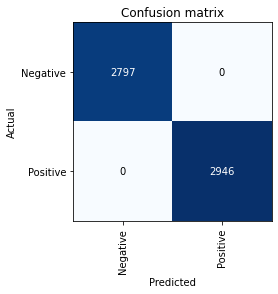

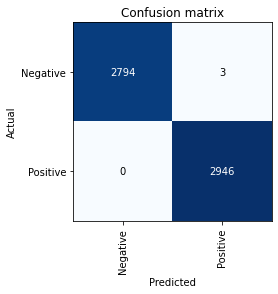

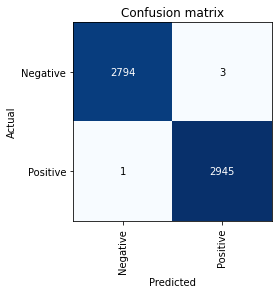

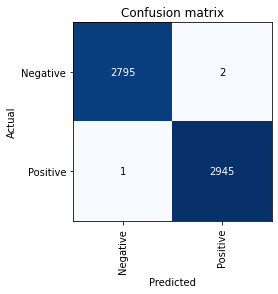

In [ ]:
interp.plot_confusion_matrix()
interp1.plot_confusion_matrix()
interp2.plot_confusion_matrix()
interp3.plot_confusion_matrix()

In [ ]:
#Prepare test predictions
ens_test_preds = [] ## Creating a list of predictions 
for mdl in ens:
    preds,_ = mdl.TTA(ds_type=DatasetType.Test)
    print(np.array(preds).shape)
    ens_test_preds.append(np.array(preds)) ## create a list of prediction numpy arrays . 

(11282, 2)


(11282, 2)


(11282, 2)


(11282, 2)


In [ ]:
ens_preds = np.mean(ens_test_preds, axis =0) ## Average the prediction from various numpy arrays using numpy mean function

In [ ]:
ens_preds

array([[9.997923e-01, 2.077950e-04],
       [9.999301e-01, 6.977662e-05],
       [9.997656e-01, 2.344187e-04],
       [9.993682e-01, 6.319335e-04],
       ...,
       [5.342250e-02, 9.465775e-01],
       [9.999160e-01, 8.404519e-05],
       [4.248846e-04, 9.995751e-01],
       [9.999486e-01, 5.148779e-05]], dtype=float32)

In [ ]:
x = np.argmax(ens_preds, axis=1)
x 

array([0, 0, 0, 0, ..., 1, 0, 1, 0])

In [ ]:
xx=['Negative', 'Positive']
y=[]
for i in x:
  y.append(xx[i])

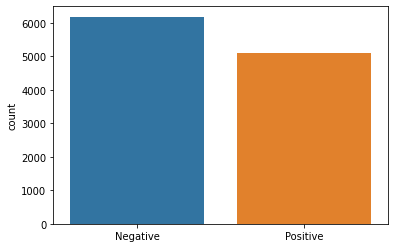

In [ ]:
sns.countplot(y)

In [ ]:
submission = pd.DataFrame({
        "prediction":y
    })
submission.to_csv('./DPHI_concrete_ensemble2.csv', index=False)
print(submission)

      prediction
0       Negative
1       Negative
2       Negative
3       Negative
4       Positive
...          ...
11277   Negative
11278   Positive
11279   Negative
11280   Positive
11281   Negative

[11282 rows x 1 columns]


**ensemble scores :99.92909058677539-attempt1**

**99.82272646693848 attempt2- unfreeze**

**99.92909058677539 attempt3**